# ECE 157B/272B Homework 1B Code
Created by: Min Jian Yang and Matthew Dupree\
Parts of the code are from:
- The PyTorch tutorial: https://pytorch.org/tutorials/beginner/transformer_tutorial.html#load-and-batch-data
- The KDnuggets tutorial: https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html

## Select a GPU Runtime
* If you would like to complete this assignment on your own computer, make sure that your computer has a GPU compatible with PyTorch hardware acceleration. Without a GPU, training the models will take a very long time.
* If you are using Google Colab, you will want to limit the amount of time you spend using a GPU runtime, to prevent running up against usage limits. If you are planning to train models this session, (i.e. beyond just vocabulary exploration,) you will need to select a GPU runtime by going to `Runtime` > `Change runtime type` > `Hardware accelerator` > `GPU`.
    * For each model you intend to train and evaluate, you will need 10-15 minutes of GPU runtime, so plan in advance.
    * If your computer goes to sleep or loses its internet connection for more than a minute or two, your Google Colab runtime will be recycled, erasing your model and training progress.


## Install Libraries
The below lab will check the versions of the PyTorch and Pandas libraries you have installed. We're expecting to see these versions of these packages, but later versions may also work fine.

In [1]:
%pip install "torch>=2.1.0" "tokenizers>=0.15.0" "matplotlib"

You may be asked to restart the kernel after running the above cell. If so, please do so and then continue running the cells below. (This means specifically to "Restart" the _kernel_, not to get a new runtime, as a new runtime will not have the package versions installed.)

## Import Libraries

In [2]:
from typing import Dict, List, Callable, Tuple, NamedTuple, Union, Optional
from collections import Counter, defaultdict
from pathlib import Path

import math
import string
import statistics

import matplotlib.pyplot as plt

import torch
from torch import Tensor, jit

import torch.nn
from torch.nn import Module
from torch.nn import RNN, LSTM, GRU, Embedding, Linear

## Unpack Data

If you are using Google Colab, you will need to upload the `data.zip` file from the assignment folder to your Colab runtime using the file browser on the left side of the screen. Also upload the `tokenizer_toy.py` file.

In [3]:
def please_upload(filename: str) -> Path:
    path = Path(filename)
    if not path.exists():
        raise FileNotFoundError(
            f"Please upload the {path.name} file from the assignment to: {Path.cwd()/path}"
        )
    return path


DATA_PATH = Path("data")
if DATA_PATH.exists() and not DATA_PATH.is_dir():
    raise NotADirectoryError(
        f"Please remove the file {DATA_PATH} from the directory and try again."
    )
if not DATA_PATH.exists():
    print("Data directory not found, creating it...")

    DATA_ZIP = please_upload("data.zip")

    print("Found {DATA_ZIP}, extracting it to {DATA_PATH}...")

    import zipfile

    with zipfile.ZipFile(DATA_ZIP, "r") as zip_ref:
        zip_ref.extractall(DATA_PATH)
    print("Done!")

# In case the data gets nested in an extra directory
if (DATA_PATH/"data").is_dir():
    print("Data directory is nested in an extra directory, unnesting it...")
    data2 = DATA_PATH.parent/"data.tmp"
    (DATA_PATH/"data").rename(data2)
    DATA_PATH.rmdir()
    data2.rename(DATA_PATH)
assert DATA_PATH.is_dir() and any(f.is_file() for f in DATA_PATH.iterdir()), "No data found in {DATA_PATH}! Something went wrong. Try deleting the \"data\" directory and running this cell again."


TOKENIZER_TOY_PATH = please_upload("tokenizer_toy.py")

print("Data directory and tokenizer_toy.py ready.")

Data directory not found, creating it...
Found {DATA_ZIP}, extracting it to {DATA_PATH}...
Done!
Data directory is nested in an extra directory, unnesting it...
Data directory and tokenizer_toy.py ready.


### Import the tokenizer
This assignment, we've split the tokenizer into a separate file, as we'd like to keep it constant across all models. This will allow us to compare the models' vocabularies and predictions more easily.

In [4]:
import tokenizer_toy

### Play with the tokenizer

The below two cells will load and train a tokenizer on the training data, allowing you to play with the tokenizer's behavior. Uncomment the cells to make use of them. (They are commented by default to allow you to run all cells without interruption.)

If you are using VSCode, the interactive behavior of the tokenizer may not work. If so, interrupt the cell and run the command after the `!` in a terminal set to the same environment and directory as this notebook. (You can use VSCode's built-in terminal for this.)

In [5]:
 #!python tokenizer_toy.py data/daily_dialog_train_text.txt

In [6]:
#!python tokenizer_toy.py data/shakespeare_train.txt

## Use GPU if available
The below line checks if a CUDA environment (typically a GPU accelerator) is available. If so, we'll use it, otherwise we'll use the CPU.

In [7]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

Using device: cuda:0


## Prepare the dataset for training

### Prepare a tokenization function

This function will take a string and return a PyTorch tensor of token IDs.

In [8]:
def tokenize_dataset(
    dataset: str,
    tokenizer: tokenizer_toy.SimpleWordPieceTokenizer
) -> torch.Tensor:
    return torch.tensor(
        tokenizer.encode(dataset).ids,
        dtype=torch.long,
    )

### Load the datasets

As both datasets have been separated into train and validation sets for you, we can greatly simplify the dataset loading process from the previous assignment.

In [9]:
def load_dataset(
    filename: Union[str, Path],
) -> str:
    with open(filename, "r", encoding="utf-8") as f:
        result = f.read()
    print(f"Loaded {len(result)} chars from {filename}")
    return result

shakespeare_train_text = load_dataset("data/shakespeare_train.txt")
shakespeare_val_text = load_dataset("data/shakespeare_val.txt")
daily_dialog_train_text = load_dataset("data/daily_dialog_train_text.txt")
daily_dialog_val_text = load_dataset("data/daily_dialog_val_text.txt")

Loaded 5251671 chars from data/shakespeare_train.txt
Loaded 288917 chars from data/shakespeare_val.txt
Loaded 6016419 chars from data/daily_dialog_train_text.txt
Loaded 556246 chars from data/daily_dialog_val_text.txt


### Build vocabularies

In [10]:
shakespeare_only_tokenizer = tokenizer_toy.SimpleWordPieceTokenizer(
    training_files=["data/shakespeare_train.txt"]
)
print("Shakespeare tokenizer vocab size:", shakespeare_only_tokenizer.get_vocab_size())

daily_dialog_only_tokenizer = tokenizer_toy.SimpleWordPieceTokenizer(
    training_files=["data/daily_dialog_train_text.txt"]
)
print("Daily Dialog tokenizer vocab size:", daily_dialog_only_tokenizer.get_vocab_size())

both_tokenizer = tokenizer_toy.SimpleWordPieceTokenizer(
    training_files=["data/shakespeare_train.txt", "data/daily_dialog_train_text.txt"]
)
print("Combined tokenizer vocab size:", both_tokenizer.get_vocab_size())

Shakespeare tokenizer vocab size: 19864
Daily Dialog tokenizer vocab size: 17823
Combined tokenizer vocab size: 20001


### Tokenize the datasets

Because we have three different tokenizers and two different datasets, we'll need to tokenize each dataset with each tokenizer. We'll do this in a nested loop, so that we can keep track of which tokenizer was used for each dataset.

In [11]:
tokenizers = {
    'shakespeare_tok': shakespeare_only_tokenizer,
    'daily_dialog_tok': daily_dialog_only_tokenizer,
    'both_tok': both_tokenizer
}
datasets = {
    'shakespeare_train_text': shakespeare_train_text,
    'daily_dialog_train_text': daily_dialog_train_text,
}
tokenized_datasets = {}
for tok_name, tok in tokenizers.items():
    for dataset_name, dataset in datasets.items():
        print(f"Tokenizing {dataset_name} with {tok_name}...", end="")
        result = tokenize_dataset(dataset, tok)
        tokenized_datasets[f"{dataset_name}_{tok_name}"] = result
        print(f"({len(result)} tokens) Done!")

Tokenizing shakespeare_train_text with shakespeare_tok...(1338874 tokens) Done!
Tokenizing daily_dialog_train_text with shakespeare_tok...(1495274 tokens) Done!
Tokenizing shakespeare_train_text with daily_dialog_tok...(1625161 tokens) Done!
Tokenizing daily_dialog_train_text with daily_dialog_tok...(1367246 tokens) Done!
Tokenizing shakespeare_train_text with both_tok...(1349630 tokens) Done!
Tokenizing daily_dialog_train_text with both_tok...(1375910 tokens) Done!


### Analyze Tokenizer Differences

The tokenizers above differ only by their vocabularies. Below, we'll compute a few metrics to compare the vocabularies' contents.

Individual metrics:

* Vocabulary Size: How many tokens are in each tokenizer's vocabulary?
* Token Types: How many tokens are of each of the following types:
    * Alphabetic: Contains only letters
    * Numeric: Contains only numbers
    * Alphanumeric: Contains both letters and numbers
    * Whitespace: Contains only whitespace
    * Punctuation: Contains only punctuation
    * Subword: Begins with `##`
* Token Length Curves: We'll plot the length of each token in the two tokenizers' vocabularies. This will allow us to see how the tokenizers' vocabularies differ in terms of the tokens' lengths -- how many characters each token contains. (Are we learning large words or lots of small, strange combinations of characters?)

Dataset-specific metrics:
* Encoded Token Counts: Count how many tokens total a tokenizer needs to encode each dataset. This will allow us to see how the tokenizers' vocabularies differ in terms of compressing the data.
* Token Frequency Curves: We'll plot the frequency of each token in the two tokenizers' vocabularies. This will allow us to see how the tokenizers' vocabularies differ in terms of the tokens' relative frequencies -- how often each token appears in the datasets they were trained on.

Comparison metrics:

* Intersection: How many tokens do the two tokenizers have in common?
* Union: How many tokens do the two tokenizers have in total between the two?
* Jaccard Index: The Jaccard index is a measure of similarity between two sets. It is defined as the size of the intersection divided by the size of the union of the two sets. In this case, we'll use it to measure how similar the two tokenizers' vocabularies are -- how many tokens they have in common out of the total number of tokens they have.

=== shakespeare_tok ===
Vocab size: 19864
Token Type Counts:
	Alphabetic:   16811
	Numeric:      10
	Alphanumeric: 16822
	Whitespace:   1
	Punctuation:  12
	Subword:      3001
Token length distribution:
	Min: 1 (48 tokens)
	Max: 17 ['undistinguishable']
	Mean: 6.381242448650825
	Median: 6 (3908 tokens)
	Histogram:


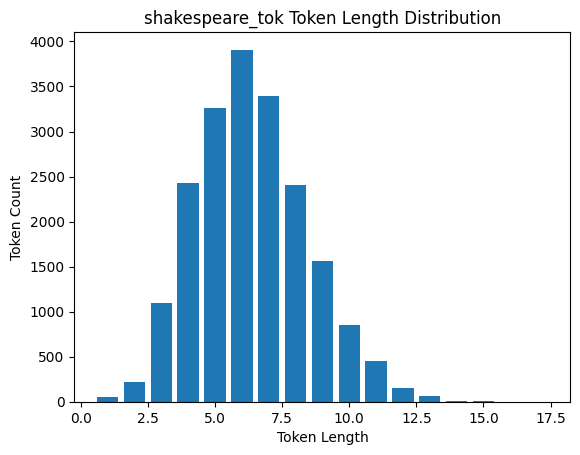

=== daily_dialog_tok ===
Vocab size: 17823
Token Type Counts:
	Alphabetic:   14287
	Numeric:      322
	Alphanumeric: 14684
	Whitespace:   1
	Punctuation:  23
	Subword:      3093
Token length distribution:
	Min: 1 (73 tokens)
	Max: 19 ['hydrochlorothiazide']
	Mean: 6.35431745497391
	Median: 6 (3130 tokens)
	Histogram:


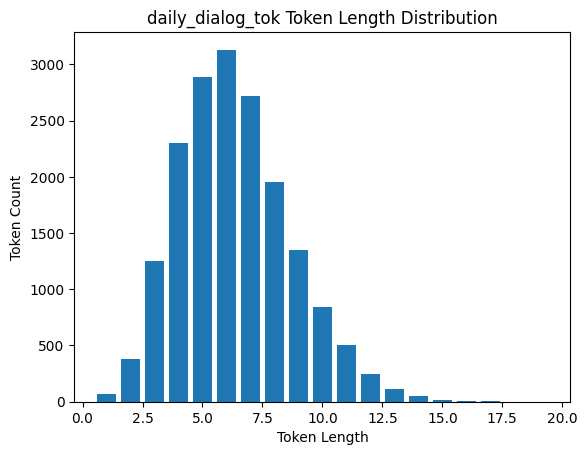

=== both_tok ===
Vocab size: 20001
Token Type Counts:
	Alphabetic:   16539
	Numeric:      153
	Alphanumeric: 16724
	Whitespace:   1
	Punctuation:  25
	Subword:      3208
Token length distribution:
	Min: 1 (75 tokens)
	Max: 16 ['enthusiastically', 'misunderstanding', 'responsibilities']
	Mean: 6.234438278086095
	Median: 6 (3842 tokens)
	Histogram:


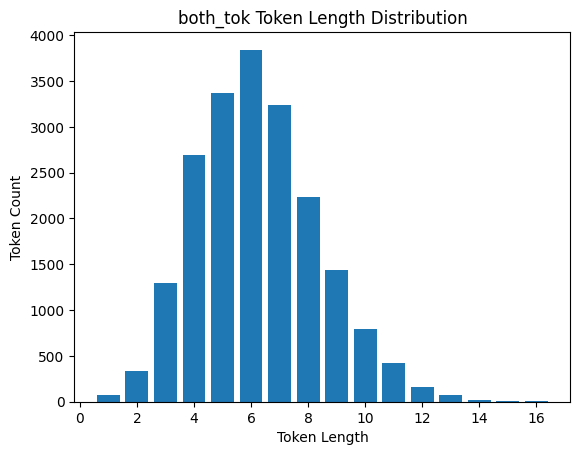

In [12]:
def token_len_operation(
    tokens: List[str],
    token_lengths: List[int],
    operation_name: str,
    operation: Callable[[List[int]], int]
) -> None:
    target_token_length = operation(token_lengths)
    target_length_tokens = [t for t in tokens if len(t) == target_token_length]
    if len(target_length_tokens) < 5:
        print(f"\t{operation_name}: {target_token_length} {target_length_tokens}")
    else:
        print(f"\t{operation_name}: {target_token_length} ({len(target_length_tokens)} tokens)")

for tok_name, tok in tokenizers.items():
    # Individual Metrics
    print(f"=== {tok_name} ===")
    vocab: Dict[str, int] = tok.get_vocab()
    print(f"Vocab size: {len(vocab)}")
    print("Token Type Counts:")
    print("\tAlphabetic:  ", sum(t.isalpha() for t in vocab))
    print("\tNumeric:     ", sum(t.isnumeric() for t in vocab))
    print("\tAlphanumeric:", sum(t.isalnum() for t in vocab))
    print("\tWhitespace:  ", sum(t.isspace() for t in vocab))
    print("\tPunctuation: ", sum(t in string.punctuation for t in vocab))
    print("\tSubword:     ", sum(t.startswith("##") for t in vocab))

    print("Token length distribution:")
    tokens = list(vocab.keys())
    token_lengths = [len(t) for t in tokens]
    token_len_operation(tokens, token_lengths, "Min", min)
    token_len_operation(tokens, token_lengths, "Max", max)
    print("\tMean:", statistics.mean(token_lengths))
    token_len_operation(tokens, token_lengths, "Median", statistics.median_low)
    print("\tHistogram:")
    counts = Counter(token_lengths)
    plt.figure()
    plt.bar(counts.keys(), counts.values())
    plt.title(f"{tok_name} Token Length Distribution")
    plt.xlabel("Token Length")
    plt.ylabel("Token Count")
    plt.show()


=== shakespeare_tok on shakespeare_train_text ===
Dataset size: 1338874 tokens
Token frequency distribution:
	Min: 0
	Max: 118449
	Mean: 67.40203094482422
	Median: 4.0
	Histogram:


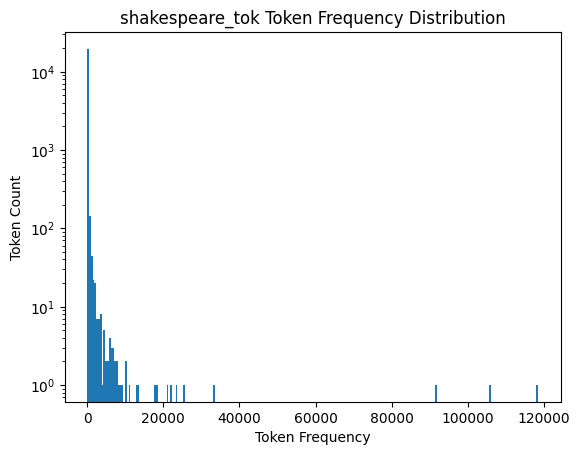

=== shakespeare_tok on daily_dialog_train_text ===
Dataset size: 1495274 tokens
Token frequency distribution:
	Min: 0
	Max: 103347
	Mean: 75.27557373046875
	Median: 0.0
	Histogram:


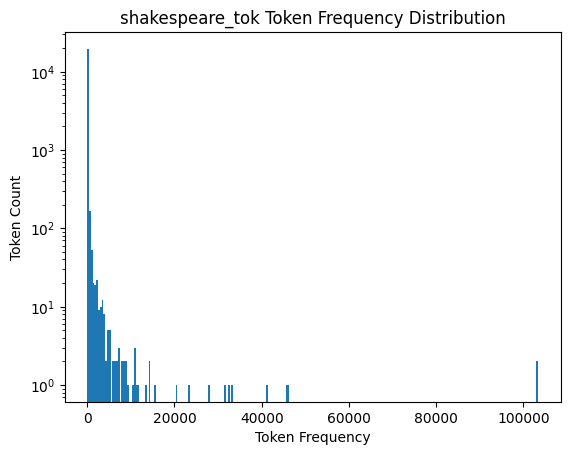

=== daily_dialog_tok on shakespeare_train_text ===
Dataset size: 1625161 tokens
Token frequency distribution:
	Min: 0
	Max: 118527
	Mean: 91.18335723876953
	Median: 1.0
	Histogram:


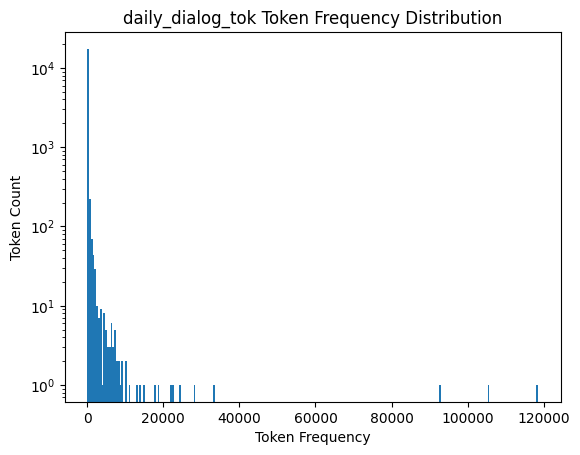

=== daily_dialog_tok on daily_dialog_train_text ===
Dataset size: 1367246 tokens
Token frequency distribution:
	Min: 0
	Max: 101547
	Mean: 76.71244812011719
	Median: 3.0
	Histogram:


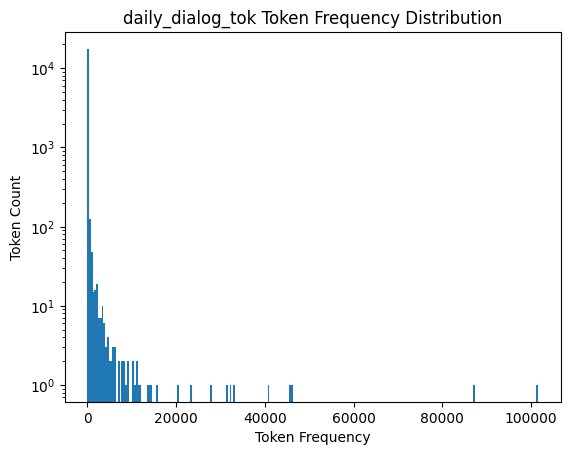

=== both_tok on shakespeare_train_text ===
Dataset size: 1349630 tokens
Token frequency distribution:
	Min: 0
	Max: 118449
	Mean: 67.4781265258789
	Median: 4.0
	Histogram:


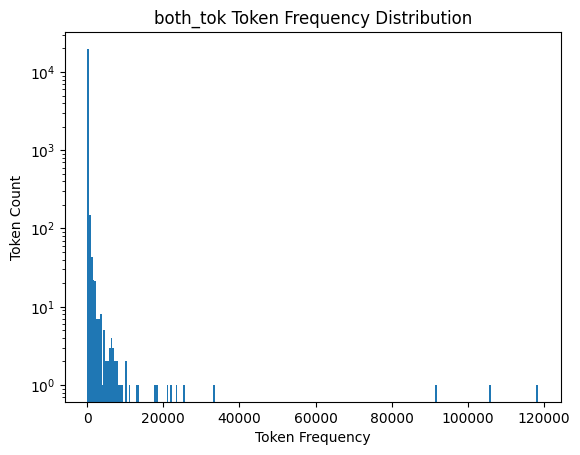

=== both_tok on daily_dialog_train_text ===
Dataset size: 1375910 tokens
Token frequency distribution:
	Min: 0
	Max: 101547
	Mean: 68.79206085205078
	Median: 3.0
	Histogram:


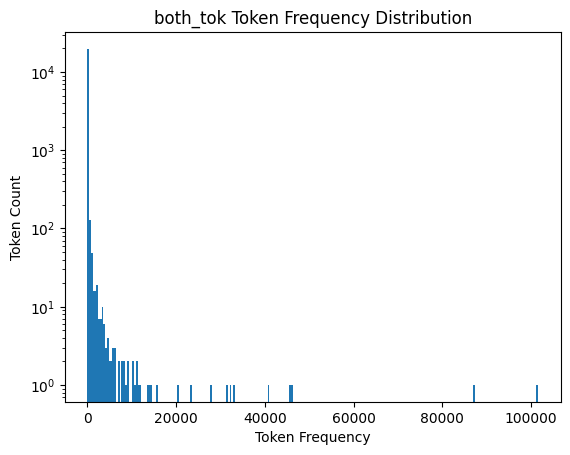

In [13]:
# Dataset-specific metrics
for tok_name in tokenizers:
    for dataset_name in datasets:
        print(f"=== {tok_name} on {dataset_name} ===")
        result = tokenized_datasets[f"{dataset_name}_{tok_name}"]
        print(f"Dataset size: {len(result)} tokens")
        print("Token frequency distribution:")
        token_counts = torch.bincount(result)
        print("\tMin:", token_counts.min().item())
        print("\tMax:", token_counts.max().item())
        print("\tMean:", token_counts.float().mean().item())
        print("\tMedian:", token_counts.float().median().item())
        print("\tHistogram:")
        plt.figure()
        plt.hist(token_counts, bins=250, log=True)
        plt.title(f"{tok_name} Token Frequency Distribution")
        plt.xlabel("Token Frequency")
        plt.ylabel("Token Count")
        plt.show()

In [14]:
# Comparison metrics
for tok_name1, tok in tokenizers.items():
    for tok_name2, tok in tokenizers.items():
        if tok_name1 <= tok_name2:
            continue
        print(f"=== {tok_name1} vs {tok_name2} ===")
        vocab1: Dict[str, int] = tokenizers[tok_name1].get_vocab()
        vocab2: Dict[str, int] = tokenizers[tok_name2].get_vocab()
        vocab1_set = set(vocab1.keys())
        vocab2_set = set(vocab2.keys())
        intersection = vocab1_set.intersection(vocab2_set)
        union = vocab1_set.union(vocab2_set)
        print(f"\t{tok_name1} has {len(vocab1_set)} tokens")
        print(f"\t{tok_name2} has {len(vocab2_set)} tokens")
        print(f"\tIntersection has {len(intersection)} tokens")
        print(f"\tUnion has {len(union)} tokens")
        print(f"\tJaccard Similarity: {len(intersection) / len(union)}")
        print(f"\t{tok_name1}-only tokens: {len(vocab1_set - vocab2_set)} tokens")
        print(f"\t{tok_name2}-only tokens: {len(vocab2_set - vocab1_set)} tokens")

=== shakespeare_tok vs daily_dialog_tok ===
	shakespeare_tok has 19864 tokens
	daily_dialog_tok has 17823 tokens
	Intersection has 7941 tokens
	Union has 29746 tokens
	Jaccard Similarity: 0.26696026356484903
	shakespeare_tok-only tokens: 11923 tokens
	daily_dialog_tok-only tokens: 9882 tokens
=== shakespeare_tok vs both_tok ===
	shakespeare_tok has 19864 tokens
	both_tok has 20001 tokens
	Intersection has 14173 tokens
	Union has 25692 tokens
	Jaccard Similarity: 0.551650319165499
	shakespeare_tok-only tokens: 5691 tokens
	both_tok-only tokens: 5828 tokens
=== daily_dialog_tok vs both_tok ===
	daily_dialog_tok has 17823 tokens
	both_tok has 20001 tokens
	Intersection has 12772 tokens
	Union has 25052 tokens
	Jaccard Similarity: 0.5098195752834105
	daily_dialog_tok-only tokens: 5051 tokens
	both_tok-only tokens: 7229 tokens


## Finalize Tokenizer and Dataset

Now that we've analyzed the tokenizers' tradeoffs, we'll select the `both_tokenizer` as our final tokenizer, as it has the largest vocabulary and high Jaccard index with both of the other tokenizers. Its compression of both datasets is also comparable to the other tokenizers' individual compression of their respective datasets.

By saving the Tokenizer, we can load it later without having to retrain it, which will save us time. It also allows us to keep it constant across all models, which will allow us to compare the models' vocabularies and predictions more easily.

### Save the tokenizer

In [15]:
both_tokenizer.save("tokenizer.json")

### Re-load the tokenizer
For future runs, you can skip here after "Load the datasets" when you want to use the same tokenizer.

In [16]:
tokenizer = tokenizer_toy.SimpleWordPieceTokenizer.load("tokenizer.json")

### Tokenize the datasets

In [17]:
shakespeare_train_tokens = tokenize_dataset(shakespeare_train_text, tokenizer)
print("shakespeare_train_tokens:", len(shakespeare_train_tokens), "tokens")
shakespeare_val_tokens = tokenize_dataset(shakespeare_val_text, tokenizer)
print("shakespeare_val_tokens:", len(shakespeare_val_tokens), "tokens")
daily_dialog_train_tokens = tokenize_dataset(daily_dialog_train_text, tokenizer)
print("daily_dialog_train_tokens:", len(daily_dialog_train_tokens), "tokens")
daily_dialog_val_tokens = tokenize_dataset(daily_dialog_val_text, tokenizer)
print("daily_dialog_val_tokens:", len(daily_dialog_val_tokens), "tokens")

shakespeare_train_tokens: 1349630 tokens
shakespeare_val_tokens: 78455 tokens
daily_dialog_train_tokens: 1375910 tokens
daily_dialog_val_tokens: 126932 tokens


## Batchify dataset
- Create batches out of the long list of number
- This allows for parallel computation during training
- Drawback being the relationship between the batches are not learned

See this link for more detail: https://pytorch.org/tutorials/beginner/transformer_tutorial.html#load-and-batch-data

In [18]:
@torch.jit.script
def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data

## Generate input and target sequence
- Grab an input sequence with length `seq_len` from the batchify data starting at index `i`
- The target sequence also has the same length `seq_len` but the starting index is `i+1`

See this link for more detail: https://pytorch.org/tutorials/beginner/transformer_tutorial.html#functions-to-generate-input-and-target-sequence

In [19]:
def get_batch(source: Tensor, i: int, bptt: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [20]:
print("shakespeare_train_text", len(batchify(shakespeare_train_tokens, 64)))
print("daily_dialog_train_text", len(batchify(daily_dialog_train_tokens, 64)))

shakespeare_train_text 21087
daily_dialog_train_text 21498


In [21]:
# Example batch drawn from the data and decoded
# to show what the model will be predicting against
def print_example_batch(tokenizer: tokenizer_toy.SimpleWordPieceTokenizer, training_data: Tensor):
    example_batch = batchify(training_data, 2)
    example_data, example_targets = get_batch(example_batch, 6485, 55)
    print(f"Example data: {example_data.t()}")
    print(f"Example targets: {example_targets}")
    print(
        f"=== Example data[0] decoded ===\n{tokenizer.decode(example_data[:, 0].tolist())}"
    )
    print(
        f"=== Example data[1] decoded ===\n{tokenizer.decode(example_data[:, 1].tolist())}"
    )
    print(
        f"=== Example targets decoded ===\n{tokenizer.decode(example_targets.tolist()[:20])}"
    )


print("=== Shakespeare ===")
print_example_batch(tokenizer, shakespeare_train_tokens)
print("=== Daily Dialog ===")
print_example_batch(tokenizer, daily_dialog_train_tokens)

=== Shakespeare ===
Example data: tensor([[19753,    14, 20000,   566,    26,   860,    43,   986,  3073,   145,
           550,   791,    12, 20000,   566,    26,  3918,   158,   556,     7,
            53,  5343,    12,  4192,    12,  4434,   145, 13203,    12, 20000,
           566,    26,  6990,   199,  1714, 17034,   145, 17303,  4624,    12,
         20000,   566,    26,    43,   498,   160,  3288,    35, 18118,  2983,
            14, 20000,   566,    26,   986],
        [ 8011,    80,   483,    14, 20000,   296,    26,   193,    13,   477,
          2472, 20000,  2472,    26,   588,   208,  4737,    12,   588,   208,
           158,  3374,    12, 20000,  2472,    26,   987, 15849,    84,   199,
           131,  5936,   145,  5269,   199, 13595,    12, 20000,  2472,    26,
            43,   216,   236,  2138, 12165,    77,    12,   236,  2138,   222,
            12, 20000,  2472,    26,   176]])
Example targets: tensor([   14,    80, 20000,   483,   566,    14,    26, 20000,   86

## Create recurrent neural network model
A recurrent neural network with an embedding layer, one or more recurrent layers, and a linear layer.

We use this `RecurrentModel` class to describe the behavior of the embedding and output layers, which are the same no matter which recurrent unit we use. We then pass the recurrent unit as a parameter to the `RecurrentModel` constructor to describe the behavior of the recurrent layers. This lets us easily create models with different recurrent units to compare their performance.

Once again, this model has not changed from the last assignment. Copy over your `forward` implementation from before.

In [52]:
class RecurrentModel(Module):
    """The recurrent neural network."""

    # __init__ is the constructor.
    # It sets up new instances of the class.
    def __init__(
        self,
        vocab_size: int,
        recurrent_module: Union[RNN, LSTM, GRU],
    ) -> None:
        """Initialize the recurrent neural network.

        Note: For this model architecure, if the number of layers is greater
        than 1, then embedding size and hidden size must be equal.

        Args:
            vocab_size (int): The number of vocabulary in the dataset.
            embedding_dim (int): The dimension of the embedding output.
            hidden_size (int): The size of the recurrent unit's hidden state.
            num_layers (int): The number of recurrent unit layers.

        Raises:
            ValueError: If the number of layers is greater than 1 and the
            embedding size is not equal to the hidden size.
        """
        # First, we call the superclass constructor
        # to give PyTorch a chance to set up the
        # parts of the object it needs to.
        super().__init__()

        # num_layers is how many layers the recurrent unit has.
        num_layers = recurrent_module.num_layers

        # hidden_size is the size of the hidden state of the recurrent unit.
        hidden_size = recurrent_module.hidden_size

        # embedding_dim is the size of the embedding output.
        embedding_dim = recurrent_module.input_size

        if (num_layers > 1) and (hidden_size != embedding_dim):
            raise ValueError(
                "When the number of layers is greater than 1, the embedding "
                "size and hidden size must be equal."
            )

        # The embedding layer turns the token IDs into embedding vectors.
        # This is a matrix of size [vocab_size, embedding_dim].
        # Each row of the matrix corresponds to one token in the vocabulary,
        #  providing a sort of "meaning in isolation" for that token.
        # The embedding layer is a trainable part of the model,
        #  so it will be updated during training.
        # The values start out initialized randomly.
        self.embedding = Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim
        )

        # The recurrent module is the main part of the model.
        # It takes in a sequence of embedding vectors
        #  and spreads information across the sequence.
        self.rnn = recurrent_module

        # The linear layer is the output layer of the model.
        # It takes in the final embedding vector from the
        #  recurrent module and outputs a vector of size [vocab_size].
        # This vector contains a score for each token in the vocabulary.
        # The token with the highest score is the one the model predicts
        #  as the next token, so the model will try to make the score
        #  for the correct token as high as possible.
        self.linear = Linear(hidden_size, vocab_size)

    # The forward method is called when we pass data through the model.
    def forward(
        self,
        x: Tensor,
        prev_state: Optional[Union[Tensor, Tuple[Tensor, Tensor]]],
    ) -> Tuple[Tensor, Union[Tensor, Tuple[Tensor, Tensor]]]:
        """Pass the a batch of data through the recurrent neural network model
        along with the previous state.

        Args:
            x (Tensor): The batch of data.
            prev_states (Tensor): The previous states of the recurrent units.

        Returns:
            Tuple[Tensor, Tensor]: The logits and hidden states.
        """

        # The embedding layer turns the token IDs into embedding vectors.
        # TODO: Embed the input tokens using the embedding layer.
        embedded = self.embedding(x)

        # The recurrent module takes in a sequence of embedding vectors
        #  and spreads information across the sequence via its hidden state.
        # TODO: Pass the embedded input tokens into the recurrent module along with the previous state.
        output, final_states = self.rnn(embedded, prev_state)

        # The linear layer takes in the final embedding vector from the
        #  recurrent module and outputs a vector of size [vocab_size].
        # TODO: Pass the final embedding vector into the linear layer to get the logits.
        logits = self.linear(output)

        # Return the logits and the final states.
        # TODO: Return the logits and the final states.
        return logits, final_states

    @torch.jit.export
    def detach_state_(self, states: Union[Tensor, Tuple[Tensor, Tensor]]) -> None:
        """Detach the state of the recurrent units.

        This function is used to make sure the model doesn't try to backpropagate
        through the entire history of the sequence, as our computers can't
        handle that much data.

        Args:
            states (Union[Tensor, Tuple[Tensor, Tensor]]): The states of the
            recurrent units.
        """
        if isinstance(states, Tensor):
            states.detach_()
        elif isinstance(states, tuple):
            for state in states:
                state.detach_()

## Parameters to tune for your experiments
The block below defines a "Parameters" class that you can use to configure settings for training runs of your various models. We will guide you through creating training functions that will make use of these parameters to allow you to create mostly-reusable code.

In [36]:
class Parameters(NamedTuple):
    ### Dataset and training parameters
    # How many different chunks of text to train on at the same time
    BATCH_SIZE: int
    # Token target -- how many tokens to backpropagate through at most
    BPTT: int
    # Learning rate
    LR: float
    # Number of epochs to train for
    EPOCHS: int

    ### Model parameters
    # Number of dimensions in the embedding of each token.
    #   More dimensions --> more meaning, but more computation
    EMBEDDING_DIM: int
    # Number of dimensions in the hidden state in the recurrent model
    HIDDEN_DIM: int
    # Number of hidden layers in the recurrent model
    NUM_LAYERS: int

## Define training and evaluation functions
- `train_epoch` trains the model for one epoch
- `evaluate` evaluates the model on the validation set
- `train_run` trains the model for all `EPOCHS` epochs and prints as it goes

In [37]:
def train_epoch(model: RecurrentModel, vocab_size: int, optimizer: torch.optim.Optimizer, train_data: Tensor, parameters:Parameters) -> Tuple[float,float]:
    """Training function for our recurrent model.

    Args:
        model (RecurrentModel): The model to train.
        train_data (Tensor): Batchified training data.
    """
    # Turn on training mode which enables training-specific
    # layer functionality (e.g. dropout)
    model.train()

    # Keep track of the loss as we go
    total_loss: float = 0.

    # Determine how many steps we'll need to cover the whole dataset
    num_batches: int = len(train_data) // parameters.BPTT

    # Keep track of the hidden state between batches.
    state = None

    # For each of our batches
    for i in range(0, train_data.size(0) - 1, parameters.BPTT):
        # Throw away gradients from previous step
        optimizer.zero_grad()

        # Get our input and target batches
        data, targets = get_batch(train_data, i, parameters.BPTT)

        # Evaluate the model to get logits and the new hidden state
        output, state = model(data, state)

        # Compute the loss
        loss = torch.nn.functional.cross_entropy(output.view(-1, vocab_size), targets)

        # Make sure the state does not carry gradients
        # between batches so we avoid a runaway memory leak
        model.detach_state_(state)

        # Compute gradients
        loss.backward()

        # Clip the gradients to avoid exploding gradients
        # (Ask us TAs if you're curious why this is necessary)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        # Update the parameters
        optimizer.step()

        # Keep track of the loss
        total_loss += loss.item()

    # Return the average loss across batches
    cur_loss = total_loss / num_batches
    # and the perplexity
    ppl = math.exp(cur_loss)
    return cur_loss, ppl


In [38]:
def evaluate(model: RecurrentModel, vocab_size: int, val_data: Tensor, parameters: Parameters) -> Tuple[float, float]:
    """Evaluate the perplexity of the model on the validation data.

    Args:
        model (RecurrentModel): The model to evaluate.
        val_data (Tensor): Batchified validation data.

    Returns:
        float: The perplexity of the model on the validation data.
    """
    # Turn on evaluation mode which disables
    # training-specific functionality (e.g. dropout)
    model.eval()

    # Keep track of the loss as we go
    total_loss: float = 0.

    # Determine how many steps we'll need to cover the whole dataset
    num_batches: int = len(val_data) // parameters.BPTT

    # Keep track of the hidden state between batches.
    state = None
    with torch.no_grad(): # No need to track gradients here, since we're not training
        for i in range(0, val_data.size(0) - 1, parameters.BPTT):
            # Get our input and target batches
            data, targets = get_batch(val_data, i, parameters.BPTT)

            # Evaluate the model to get logits and the new hidden state
            output, state = model(data, state)

            # Compute the loss
            loss = torch.nn.functional.cross_entropy(output.view(-1, vocab_size), targets)
            total_loss += loss.item()

    # Return the average loss across batches
    cur_loss = total_loss / num_batches
    # and the perplexity
    ppl = math.exp(cur_loss)
    return cur_loss, ppl

In [39]:
def train_run(model: RecurrentModel, vocab_size: int, train_data: Tensor, validation_data: Tensor, parameters: Parameters, verbose: bool = True) ->None:
    """Train a model for NUM_EPOCHS epochs.
    """
    # Here we define an optimizer and scheduler to use for training.
    # An optimizer adjusts the parameters of the model based on the loss
    # and the gradients of the parameters with respect to the loss.

    # Adam is a popular optimizer that tends to work well in practice.
    # optimizer = torch.optim.Adam(model.parameters(), lr=parameters.LR) # Set LR to about 0.005 to start

    # AdamW corrects a minor flaw in the original Adam implementation
    # allowing it to converge slightly better.
    optimizer = torch.optim.AdamW(model.parameters(), lr=parameters.LR) # Set LR to about 0.01

    # SGD is the simple stochastic gradient descent algorithm,
    # implemented as LR * gradient.
    # Notably, the RNNs shown here need a strong learning rate to
    # even begin to move the loss, so we start with a high LR.
    # optimizer = torch.optim.SGD(model.parameters(), lr=parameters.LR) # Set LR to about 10.0 to start

    # The scheduler adjusts the learning rate over time.
    # Here we use a scheduler that decreases the learning rate
    # by a factor of 0.5 if the training loss doesn't decrease
    # for two epochs in a row.
    # This makes sure that the model can converge down into a
    # minimum once it finds one, instead of bouncing around.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1, threshold=1e-3)

    # Train for NUM_EPOCHS epochs
    for epoch in range(1,parameters.EPOCHS+1,1):
        if verbose:
            # Print out an initial message stating the epoch number
            # and learning rate
            lrs = [group['lr'] for group in optimizer.param_groups]
            lr = lrs[0] if len(lrs) > 0 else -1
            # The end='' argument tells Python not to print a newline
            # so we can extend this row with more information
            # as we compute it.
            print(f'| epoch {epoch:3d} | lr {lr:03.3f} | ', end='')

        # Train for one epoch
        loss, ppl = train_epoch(model, vocab_size, optimizer, train_data, parameters)

        # Update the learning rate
        scheduler.step(loss)
        # Note that we can move this line after the validation step
        # if we want to update the learning rate based on the val
        # loss instead of the training loss.

        if verbose:
            # Update the printed row with the training loss and perplexity
            # so that the user knows the training step completed and that
            # we're now evaluating on the validation set.
            print(f'train loss {loss:5.2f} | train ppl {ppl:8.2f} | ', end='')

        # Evaluate on the validation set
        val_loss, val_ppl = evaluate(model, vocab_size, validation_data, parameters)

        if verbose:
            # Update the printed row with the validation loss and perplexity
            print(f'val loss {val_loss:5.2f} | val ppl {val_ppl:8.2f} |')
            # We no longer have the end='' argument, so this completes the line.

In [40]:
def generate_text(
    tokenizer: tokenizer_toy.SimpleWordPieceTokenizer,
    model: RecurrentModel,
    input_text: str,
    num_tokens_to_generate: int,
    by_prob: bool = False,
) -> str:
    """Input a text and use the model generate the next `n` words.

    Args:
        tokenizer (Tokenizer): The tokenizer used in training.
        model (RNNModel): A trained recurrent neural network model.
        text (str): A string of text to generate the text off of.
        num_words (int, optional): The number of words to generate.
            Defaults to 10.
        by_prob (bool, optional): If `True`, words are randomly generated
            based on probability. If `False`, words are generated based on
            highest probability. Defaults to False.

    Returns:
        str: Generated text string.
    """

    # Set the model to evaluation mode (no Dropout and the like)
    model.eval()

    with torch.no_grad(): # Disable gradient calculation because we won't use it

        # Process our input text
        data = tokenize_dataset(input_text, tokenizer)
        # Turn it into a batch for the model
        x = data.reshape((-1, 1)).to(DEVICE)

        state = None # Start with a blank state
        output_tokens = [] # Keep track of the generated tokens
        for _ in range(num_tokens_to_generate):
            # Get the model's predicted next token
            y_pred, state = model(x, state)
            # We only care about the last token's predictions
            last_word_logits = y_pred[-1][0]

            # If we're generating by probability, we'll randomly choose a word
            if by_prob:
                # Normalize the logits so they form a probability distribution
                p = (
                    torch.nn.functional.softmax(last_word_logits, dim=0)
                )
                # Randomly choose the next word based on the probability
                word_index = p.multinomial(num_samples=1).cpu().item()
            else:
                # Otherwise, we'll just choose the word with the highest probability
                word_index = torch.argmax(last_word_logits)

            # Add the generated word to our output
            output_tokens.append(word_index)

            # Add the generated word as the next input to the model
            x = torch.tensor([word_index]).reshape(1, 1).to(DEVICE)

    # Decode the generated tokens and return the result
    return tokenizer.decode(output_tokens)

In [57]:
def create_model(
    vocab_size: int,
    parameters: Parameters,
    model_type: Callable[..., Union[RNN, LSTM, GRU]],
    script: bool = True,
) -> RecurrentModel:
    """Create a recurrent model.

    Args:
        vocab_size (int): The number of vocabulary in the dataset.
        parameters (Parameters): The model parameters.
        model_type (Callable[..., Union[RNN, LSTM, GRU]]): The type of recurrent
            model to create.

    Returns:
        RecurrentModel: The recurrent model.
    """
    # Create the model
    # We've split the model into two pieces:
    # 1. The RecurrentModel class, which defines the overall model architecture
    #    including the embedding and output layer
    # 2. The RNN, LSTM, or GRU class, which defines the recurrent unit
    #    that will be used inside the model.
    # This allows us to easily swap out different recurrent units
    # without having to rewrite the whole model's code
    # across multiple notebooks or cells.

    # The added "torch.jit.script" is a magic incantation that
    # tells PyTorch to compile the model into a more efficient
    # representation. This is not necessary, but it makes the
    # model run faster and use less memory.

    # The flatten_parameters() call is also not strictly necessary,
    # but it makes the model run faster and use less GPU memory
    # (and gets rid of a warning message).

    instance = RecurrentModel(
        vocab_size=vocab_size,
        recurrent_module=model_type(
            input_size=parameters.EMBEDDING_DIM,
            hidden_size=parameters.HIDDEN_DIM,
            num_layers=parameters.NUM_LAYERS,
        ),
    ).to(DEVICE)
    instance.rnn.flatten_parameters()
    if script:
        instance = torch.jit.script(instance)
    return instance

def train_model(
    model: RecurrentModel,
    vocab_size: int,
    unbatched_train_data: Tensor,
    unbatched_validation_data: Tensor,
    parameters: Parameters,
    verbose: bool = True,
) -> None:
    if verbose:
        print(f'The shape of the training data is {unbatched_train_data.shape}.')
    batched_training_data = batchify(unbatched_train_data, parameters.BATCH_SIZE).to(DEVICE)
    if verbose:
        print(f'The shape of the batched training data is {batched_training_data.shape}.')
        print(f'The shape of the validation data is {unbatched_validation_data.shape}.')
    batched_validation_data = batchify(unbatched_validation_data, parameters.BATCH_SIZE).to(DEVICE)
    if verbose:
        print(f'The shape of the batched validation data is {batched_validation_data.shape}.')

    train_run(model, vocab_size, batched_training_data, batched_validation_data, parameters, verbose)
    return model


def create_and_train_model(
    vocab_size: int,
    parameters: Parameters,
    model_type: Callable[..., Union[RNN, LSTM, GRU]],
    unbatched_train_data: Tensor,
    unbatched_validation_data: Tensor,
    verbose: bool = True,
) -> RecurrentModel:
    """Create and train a recurrent model.

    Args:
        vocab_size (int): The number of vocabulary in the dataset.
        parameters (Parameters): The model parameters.
        model_type (Callable[..., Union[RNN, LSTM, GRU]]): The type of recurrent
            model to create.
        train_data (Tensor): Unbatched training data.

    Returns:
        RecurrentModel: The trained recurrent model.
    """
    model = create_model(vocab_size, parameters, model_type)
    model.to(DEVICE)

    train_model(model, unbatched_train_data, unbatched_validation_data, parameters, verbose)
    return model



## Run model-building experiments

In [58]:
parameters = Parameters(
    BATCH_SIZE=32,
    BPTT=50,
    LR=0.01,
    EPOCHS=30,
    EMBEDDING_DIM=24,
    HIDDEN_DIM=24,
    NUM_LAYERS=3,
)

shakespeare_recurrent_module = LSTM
daily_dialog_recurrent_module = RNN

In [60]:
shakespeare_model = create_model(
    vocab_size=tokenizer.get_vocab_size(),
    parameters=parameters,
    model_type=LSTM,
    script=False
)
train_model(
    model=shakespeare_model,
    vocab_size=tokenizer.get_vocab_size(),
    unbatched_train_data=shakespeare_train_tokens,
    unbatched_validation_data=shakespeare_val_tokens,
    parameters=parameters,
    verbose=True,
)

The shape of the training data is torch.Size([1349630]).
The shape of the batched training data is torch.Size([42175, 32]).
The shape of the validation data is torch.Size([78455]).
The shape of the batched validation data is torch.Size([2451, 32]).
| epoch   1 | lr 0.010 | train loss  5.85 | train ppl   348.61 | val loss  5.78 | val ppl   323.70 |
| epoch   2 | lr 0.010 | train loss  4.85 | train ppl   128.06 | val loss  5.47 | val ppl   237.88 |
| epoch   3 | lr 0.010 | train loss  4.61 | train ppl   100.92 | val loss  5.38 | val ppl   216.24 |
| epoch   4 | lr 0.010 | train loss  4.50 | train ppl    90.14 | val loss  5.32 | val ppl   205.02 |
| epoch   5 | lr 0.010 | train loss  4.43 | train ppl    83.91 | val loss  5.28 | val ppl   196.63 |
| epoch   6 | lr 0.010 | train loss  4.38 | train ppl    79.83 | val loss  5.26 | val ppl   192.39 |
| epoch   7 | lr 0.010 | train loss  4.34 | train ppl    76.96 | val loss  5.22 | val ppl   185.16 |
| epoch   8 | lr 0.010 | train loss  4.32 | 

RecurrentModel(
  (embedding): Embedding(20001, 24)
  (rnn): LSTM(24, 24, num_layers=3)
  (linear): Linear(in_features=24, out_features=20001, bias=True)
)

In [61]:
daily_dialog_model = create_model(
    vocab_size=tokenizer.get_vocab_size(),
    parameters=parameters,
    model_type=daily_dialog_recurrent_module,
    script=False
)
train_model(
    model=daily_dialog_model,
    vocab_size=tokenizer.get_vocab_size(),
    unbatched_train_data=daily_dialog_train_tokens,
    unbatched_validation_data=daily_dialog_val_tokens,
    parameters=parameters,
    verbose=True,
)

The shape of the training data is torch.Size([1375910]).
The shape of the batched training data is torch.Size([42997, 32]).
The shape of the validation data is torch.Size([126932]).
The shape of the batched validation data is torch.Size([3966, 32]).
| epoch   1 | lr 0.010 | train loss  5.41 | train ppl   222.60 | val loss  4.64 | val ppl   103.98 |
| epoch   2 | lr 0.010 | train loss  4.43 | train ppl    83.62 | val loss  4.39 | val ppl    80.29 |
| epoch   3 | lr 0.010 | train loss  4.26 | train ppl    71.11 | val loss  4.30 | val ppl    73.76 |
| epoch   4 | lr 0.010 | train loss  4.19 | train ppl    65.78 | val loss  4.26 | val ppl    71.02 |
| epoch   5 | lr 0.010 | train loss  4.14 | train ppl    63.07 | val loss  4.24 | val ppl    69.41 |
| epoch   6 | lr 0.010 | train loss  4.12 | train ppl    61.39 | val loss  4.23 | val ppl    68.38 |
| epoch   7 | lr 0.010 | train loss  4.10 | train ppl    60.08 | val loss  4.21 | val ppl    67.45 |
| epoch   8 | lr 0.010 | train loss  4.08 |

RecurrentModel(
  (embedding): Embedding(20001, 24)
  (rnn): RNN(24, 24, num_layers=3)
  (linear): Linear(in_features=24, out_features=20001, bias=True)
)

## Save final models

Just like with the Tokenizer, we can save the model so that we can load it later without having to retrain it, which will save us time.

In [63]:
torch.save(shakespeare_model.state_dict(), "shakespeare_model.pt")
torch.save(daily_dialog_model.state_dict(), "daily_dialog_model.pt")

**Remember to download the model files and tokenizer together from Colab to preserve them!**

(If running in a local Jupyter notebook instance, the files are already saved to your computer.)

### Reload the models

To run this "reload"-ing code, we'll need the definition of `RecurrentModel` to be in scope. If you've restarted your runtime, you'll need to re-run the cell where you defined `RecurrentModel` before running the below cell.

In [65]:
shakespeare_model = create_model(
    vocab_size=tokenizer.get_vocab_size(),
    parameters=parameters,
    model_type=shakespeare_recurrent_module,
    script=False

)
shakespeare_model.load_state_dict(torch.load("shakespeare_model.pt"))
daily_dialog_model = create_model(
    vocab_size=tokenizer.get_vocab_size(),
    parameters=parameters,
    model_type=daily_dialog_recurrent_module,
    script=False

)
daily_dialog_model.load_state_dict(torch.load("daily_dialog_model.pt"))

<ipython-input-65-dff9b8a38921>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  shakespeare_model.load_state_dict(torch.load("shakespeare_model.pt"))
<ipython-input-65-dff9

<All keys matched successfully>

## Test model by perplexity on datasets

In [66]:
models = {
    "shakespeare_model": shakespeare_model,
    "daily_dialog_model": daily_dialog_model,
}
datasets = {
    "shakespeare_train": shakespeare_train_tokens,
    "daily_dialog_train": daily_dialog_train_tokens,
    "shakespeare_val": shakespeare_val_tokens,
    "daily_dialog_val": daily_dialog_val_tokens,
}
for model_name, model in models.items():
    model.eval()
    for dataset_name, dataset in datasets.items():
        print(f"{dataset_name} perplexity for {model_name}:", end="")
        loss, ppl = evaluate(
            model,
            tokenizer.get_vocab_size(),
            batchify(dataset, parameters.BATCH_SIZE).to(DEVICE),
            parameters,
        )
        print(f" {ppl}")

shakespeare_train perplexity for shakespeare_model: 60.65964758061399
daily_dialog_train perplexity for shakespeare_model: 25181.800815694354
shakespeare_val perplexity for shakespeare_model: 214.64761653070724
daily_dialog_val perplexity for shakespeare_model: 28546.4863633283
shakespeare_train perplexity for daily_dialog_model: 20291.856016177244
daily_dialog_train perplexity for daily_dialog_model: 49.096048875883014
shakespeare_val perplexity for daily_dialog_model: 17309.180965540265
daily_dialog_val perplexity for daily_dialog_model: 61.70532196569676


## Test model by generating text

In [67]:
print(generate_text(
    tokenizer,
    shakespeare_model,
    "courage under this? Who else would dare",
    200,
    by_prob=True,
))

thy garter whom you 
 petruchio : thing that they when they i am a man : so child 
 mariana : in shallow ' s women. 
 narrator : enter hector and certain lords and s odds and s log it. 
 king henry vi : no, patroclus, my lordl in the song, an cordelia 
 kingush party in capulet orsino : i round on steel for cheap at soldiers and rome 
 queen. an ass deliver you 
 cardinal mowbray : sea capitnora o ' whole kin! 
 earl of worcester : therefore now he of ours will, whilst it hath 
 romeo : so ne ' er our court offence, was glad her judgments 
 adriana : a rigorous arms i have wilt my mouth of ord ' d : 
 talbot : but shall he all you lay and eat my heart 
 alencon : and by our bourn, the dream of peers. 
 narrator : re - enter king stanley cassius, bassianus, lavinia 
 regan : [ within ] a, the gods drew that good the show


In [68]:
print(generate_text(
    tokenizer,
    daily_dialog_model,
    "Hey, Thomas, could you run by the airport to pick up Ms. Davis?",
    200,
    by_prob=True,
))

__eou__ david are human island. __eou__ i ’ ll pay the piano in few days. shall we have wi pieces to leave in this family? i meant to traveldling with vegetables for korea. an no hotel! __eou__ how expensive, you ’ re tie! __eou__ how many types often flesh, i put here from joining a small challenge. __eou__ ok. don ' t rest good new bulk. __eou__ will you take? in my country printed my famous salary ' s onous. __eou__ yeah are you a time. __eou__ 
 what ' s your meals. __eou__ ok, would you put what? __eou__ i really do such your sense. __eou__ i ' m worrying you know. did you say you ' re - subway yesterday, please. __eou__ i ’ m already sure why i don ’ t feel. but not! __eou__ that ' s going that tickets at this time just well high sight before you must do. here is the sports and call the phone parlor work her better. __eou__ 
 some figures with my


## Classify text

Language models can do more than just generating samples of similar text. They can also be used to classify text. We can do this by using the model to predict an "emotion" for each chunk of the `daily_dialog` dataset, then compare the predicted emotions to the labeled emotions from the dataset.

### Prepare the dataset for classification

First, we'll need to load the daily dialog dataset's emotion labels into a list of lists -- one list for every dialog, one entry for every utterance in the dialog. We'll also need to reload the text of the dataset, as we'll need to get the same list of lists pattern for the text.

#### Load the emotions datasets

In [69]:
def load_emotions_dataset(path: Union[str, Path]) -> List[int]:
    """Load the emotions dataset.

    Args:
        path (Union[str, Path]): The path to the emotions dataset.

    Returns:
        List[List[int]]: A list of lists of emotion IDs.
    """
    with open(path, "r") as f:
        return [int(emotion) for line in f.readlines() for emotion in line.split()]

emotion_train = load_emotions_dataset("data/daily_dialog_train_emotion.txt")
emotion_val = load_emotions_dataset("data/daily_dialog_val_emotion.txt")

#### Match the emotions to the text

We know each emotion in the emotions datasets should correspond to one appearance of `__eou__` in the text dataset. We'll use this to match the emotions to the text.

In [70]:
def scatter_emotions_to_text(text_tokens: Tensor, emotion_tokens: List[int]) -> Tensor:
    # We'll return a tensor with the same shape as the text tokens but
    # with nonzero values only where the `__eou__` tokens are. These
    # nonzero values will be the corresponding emotion IDs.
    result = torch.zeros_like(text_tokens, dtype=torch.uint8)
    # Find the indices of the `__eou__` tokens
    eou_indices = (text_tokens == tokenizer.get_vocab()["__eou__"])
    # Scatter the emotion IDs into the result tensor at the `__eou__` indices
    result[eou_indices] = torch.tensor(emotion_tokens, dtype=torch.uint8)
    return result

emotion_train_tokens = scatter_emotions_to_text(daily_dialog_train_tokens, emotion_train)
emotion_val_tokens = scatter_emotions_to_text(daily_dialog_val_tokens, emotion_val)

### Replace the next-word prediction layer

By replacing the next-word prediction layer with a classification layer, we can use the model to predict the emotion of each utterance in the dataset.

We have 7 emotions in the dataset, so we'll need to replace the next-word prediction layer with a classification layer with 7 output units:

0. `No Emotion` (or missing label)
1. `Anger`
2. `Disgust`
3. `Fear`
4. `Happiness`
5. `Sadness`
6. `Surprise`


In [71]:
EMOTION_VOCAB_SIZE = 7

In [85]:
def create_fresh_emotion_classifier(
    vocab_size: int,
    parameters: Parameters,
    model_type: Callable[..., Union[RNN, LSTM, GRU]],
) -> RecurrentModel:
    daily_dialog_model = create_model(
        vocab_size=vocab_size,
        parameters=parameters,
        model_type=model_type,
        script=False # We can't precompile the model if we're going to change it
    )
    daily_dialog_model.linear = Linear(parameters.HIDDEN_DIM, EMOTION_VOCAB_SIZE).to(DEVICE)
    return daily_dialog_model

def create_text_pretrained_emotion_classifier(
    vocab_size: int,
    parameters: Parameters,
    model_type: Callable[..., Union[RNN, LSTM, GRU]],
) -> RecurrentModel:
    daily_dialog_model = create_model(
        vocab_size=vocab_size,
        parameters=parameters,
        model_type=model_type,
        script=False # We can't precompile the model if we're going to change it
    )
    daily_dialog_model.load_state_dict(torch.load("daily_dialog_model.pt"))
    daily_dialog_model.linear = Linear(parameters.HIDDEN_DIM, EMOTION_VOCAB_SIZE).to(DEVICE)
    return daily_dialog_model


### Write our new training and evaluation functions

These training functions are just like the ones we wrote for the language modeling task, but with a few key differences:

* We now only count the loss when the input token is `__eou__`, as that is the only token that has a corresponding emotion label.
* We now compute the accuracy of the model's predictions, as we can compare them to the emotion labels.
  * This is instead of perplexity, as we are no longer predicting the next word in the sequence.

Beyond these differences, the training functions are the same as before:

- `train_epoch_classifier` trains the model for one epoch
- `evaluate_classifier` evaluates the model on the validation set
- `train_run_classifier` trains the model for all `EPOCHS` epochs and prints as it goes


In [73]:
@torch.jit.script
def get_classifier_batch(
    source: Tensor,
    emotions: Tensor,
    i: int,
    bptt: int
) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        emotions: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = emotions[i:i+seq_len].reshape(-1)
    return data, target

In [74]:
def train_epoch_classifier(
    model: RecurrentModel,
    optimizer: torch.optim.Optimizer,
    train_data: Tensor,
    target_data: Tensor,
    parameters: Parameters,
    eou_token_id: int,
) -> Tuple[float, float]:
    """Training function for our recurrent model.

    Args:
        model (RecurrentModel): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        train_data (Tensor): Batchified training data.
        target_data (Tensor): Batchified target data.
        parameters (Parameters): The model parameters.
        eou_token_id (int): The ID of the `__eou__` token.
    """
    # Turn on training mode which enables training-specific
    # layer functionality (e.g. dropout)
    model.train()

    # Keep track of the loss as we go
    total_loss: float = 0.0

    # Keep track of the accuracy as we go
    # TODO: Initialize variables to keep track of the accuracy here
    total_correct = 0
    total_attempts = 0
    # Determine how many steps we'll need to cover the whole dataset
    num_batches: int = len(train_data) // parameters.BPTT

    # Keep track of the hidden state between batches.
    state = None

    # For each of our batches
    for i in range(0, train_data.size(0) - 1, parameters.BPTT):
        # Throw away gradients from previous step
        optimizer.zero_grad()

        # Get our input and target batches
        data, targets = get_classifier_batch(
            train_data, target_data, i, parameters.BPTT
        )

        # Evaluate the model to get logits and the new hidden state
        output, state = model(data, state)

        # Any tokens with an input token ID not of `__eou__` should be ignored
        # in the loss. We'll create a mask to zero out the loss for these tokens.
        mask = data.reshape(-1) == eou_token_id

        # If the mask is all False, then we don't need to compute a loss
        attempts = mask.sum().item()
        if attempts == 0:
            continue

        # Compute the accuracy
        correct = (output.argmax(dim=-1).reshape(-1)[mask] == targets[mask]).sum().item()
        # TODO: Update the accuracy variables here

        # Compute the loss
        # Note that we're using the `reduction="none"` argument here
        # so that we can zero out the loss for tokens that are not
        # `__eou__` tokens.
        loss = torch.nn.functional.cross_entropy(
            output.view(-1, EMOTION_VOCAB_SIZE), targets, reduction="none"
        )

        # Now we do our own reduction.
        loss = loss[mask].mean()

        # Make sure the state does not carry gradients
        # between batches so we avoid a runaway memory leak
        model.detach_state_(state)

        # Compute gradients
        loss.backward()

        # Clip the gradients to avoid exploding gradients
        # (Ask us TAs if you're curious why this is necessary)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        # Update the parameters
        optimizer.step()

        # Keep track of the loss
        total_loss += loss.item()

    # Return the average loss across batches
    cur_loss = total_loss / num_batches
    # and the accuracy
    # TODO: Compute the accuracy here
    accuracy = total_correct / total_attempts if total_attempts > 0 else 0.0
    return cur_loss, accuracy

In [75]:
# @torch.jit.script # If you're having trouble with this function, try commenting out this line.
def evaluate_classifier(
    model: RecurrentModel,
    val_data: Tensor,
    target_data: Tensor,
    parameters: Parameters,
    eou_token_id: int,
    emotion_vocab_size: int,
) -> Tuple[float, float]:
    """Evaluate the perplexity of the model on the validation data.

    Args:
        model (RecurrentModel): The model to evaluate.
        val_data (Tensor): Batchified validation data.

    Returns:
        float: The perplexity of the model on the validation data.
    """
    # Keep track of the loss as we go
    total_loss: float = 0.0

    # Keep track of the accuracy as we go
    # TODO: Initialize variables to keep track of the accuracy here
    total_correct = 0
    total_attempts = 0
    # Determine how many steps we'll need to cover the whole dataset
    num_batches: int = len(val_data) // parameters.BPTT

    # Keep track of the hidden state between batches.
    state = None
    with torch.no_grad():  # No need to track gradients here, since we're not training
        for i in range(0, val_data.size(0) - 1, parameters.BPTT):
            # Get our input and target batches
            data, targets = get_classifier_batch(val_data, target_data, i, parameters.BPTT)

            # Evaluate the model to get logits and the new hidden state
            output, state = model.forward(data, state)

            # Compute our new mask
            mask = data.reshape(-1) == eou_token_id

            # If the mask is all False, then we don't need to compute a loss
            attempts = mask.sum().item()
            if attempts == 0:
                continue

            # Compute the accuracy
            correct = (output.argmax(dim=-1).reshape(-1)[mask] == targets[mask]).sum().item()
            # TODO: Update the accuracy variables here
            total_correct += correct
            total_attempts += attempts

            # Compute the loss
            # Note that we're using the `reduction="none"` argument here
            # so that we can zero out the loss for tokens that are not
            # `__eou__` tokens.
            loss = torch.nn.functional.cross_entropy(output.view(-1, emotion_vocab_size), targets, reduction="none")
            loss = loss[mask].mean() # Now we do our own reduction.

            # Keep track of the total loss
            total_loss += loss.item()

    # Return the average loss across batches
    cur_loss = total_loss / num_batches
    # and the accuracy
    # TODO: Compute the final accuracy here
    accuracy = total_correct / total_attempts if total_attempts > 0 else 0.0
    accuracy = total_correct / total_attempts
    return cur_loss, accuracy

In [76]:
def train_run_classifier(
    model: RecurrentModel,
    train_data: Tensor,
    train_target_data: Tensor,
    validation_data: Tensor,
    validation_target_data: Tensor,
    eou_token_id: int,
    parameters: Parameters,
    verbose: bool = True,
) -> None:
    """Train a model for NUM_EPOCHS epochs."""
    # Here we define an optimizer and scheduler to use for training.
    # An optimizer adjusts the parameters of the model based on the loss
    # and the gradients of the parameters with respect to the loss.

    # Adam is a popular optimizer that tends to work well in practice.
    # optimizer = torch.optim.Adam(model.parameters(), lr=parameters.LR) # Set LR to about 0.005 to start

    # AdamW corrects a minor flaw in the original Adam implementation
    # allowing it to converge slightly better.
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=parameters.LR
    )  # Set LR to about 0.01

    # SGD is the simple stochastic gradient descent algorithm,
    # implemented as LR * gradient.
    # Notably, the RNNs shown here need a strong learning rate to
    # even begin to move the loss, so we start with a high LR.
    # optimizer = torch.optim.SGD(model.parameters(), lr=parameters.LR) # Set LR to about 10.0 to start

    # The scheduler adjusts the learning rate over time.
    # Here we use a scheduler that decreases the learning rate
    # by a factor of 0.5 if the training loss doesn't decrease
    # for two epochs in a row.
    # This makes sure that the model can converge down into a
    # minimum once it finds one, instead of bouncing around.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=1, threshold=1e-3
    )

    # Train for NUM_EPOCHS epochs
    for epoch in range(1, parameters.EPOCHS + 1, 1):
        if verbose:
            # Print out an initial message stating the epoch number
            # and learning rate
            lrs = [group["lr"] for group in optimizer.param_groups]
            lr = lrs[0] if len(lrs) > 0 else -1
            # The end='' argument tells Python not to print a newline
            # so we can extend this row with more information
            # as we compute it.
            print(f"| epoch {epoch:3d} | lr {lr:05.5f} | ", end="")

        # Train for one epoch
        loss, acc = train_epoch_classifier(
            model,
            optimizer,
            train_data,
            train_target_data,
            eou_token_id=eou_token_id,
            parameters=parameters,
        )

        # Update the learning rate
        scheduler.step(loss)
        # Note that we can move this line after the validation step
        # if we want to update the learning rate based on the val
        # loss instead of the training loss.

        if verbose:
            # Update the printed row with the training loss and perplexity
            # so that the user knows the training step completed and that
            # we're now evaluating on the validation set.
            print(f"train loss {loss:5.4f} | train acc {acc*100:5.2f} | ", end="")

        # Evaluate on the validation set
        model.eval()
        val_loss, val_acc = evaluate_classifier(
            model,
            validation_data,
            validation_target_data,
            eou_token_id=eou_token_id,
            parameters=parameters,
            emotion_vocab_size=EMOTION_VOCAB_SIZE,
        )

        if verbose:
            # Update the printed row with the validation loss and perplexity
            print(f"val loss {val_loss:5.4f} | val acc {val_acc*100:5.2f} |")
            # We no longer have the end='' argument, so this completes the line.

In [77]:
def train_model_classifier(
    model: RecurrentModel,
    unbatched_train_data: Tensor,
    unbatched_train_target_data: Tensor,
    unbatched_validation_data: Tensor,
    unbatched_validation_target_data: Tensor,
    eou_token_id: int,
    parameters: Parameters,
    verbose: bool = True,
) -> None:
    if verbose:
        print(
            f"The shape of the training data is {unbatched_train_data.shape} and {unbatched_train_target_data.shape}."
        )
    batched_training_data = batchify(
        unbatched_train_data, parameters.BATCH_SIZE
    ).to(DEVICE)
    batched_training_target_data = batchify(
        unbatched_train_target_data, parameters.BATCH_SIZE
    ).to(DEVICE)
    if verbose:
        print(
            f"The shape of the batched training data is {batched_training_data.shape} and {batched_training_target_data.shape}."
        )
        print(
            f"The shape of the validation data is {unbatched_validation_data.shape} and {unbatched_validation_target_data.shape}."
        )
    batched_validation_data = batchify(
        unbatched_validation_data, parameters.BATCH_SIZE
    ).to(DEVICE)
    batched_validation_target_data = batchify(
        unbatched_validation_target_data, parameters.BATCH_SIZE
    ).to(DEVICE)
    if verbose:
        print(
            f"The shape of the batched validation data is {batched_validation_data.shape} and {batched_validation_target_data.shape}."
        )

    train_run_classifier(
        model,
        batched_training_data,
        batched_training_target_data,
        batched_validation_data,
        batched_validation_target_data,
        eou_token_id=eou_token_id,
        parameters=parameters,
        verbose=verbose,
    )
    return model

### Run model building experiments

In [78]:
# Redefine the parameters object so you can play with them, if desired.
# When training the classifier, as we're only including some tokens in the loss,
# the calculations are less intensive and we can support a larger batch size.
# You may also want to play with Learning Rate.
classifier_parameters = Parameters(
    BATCH_SIZE=4*parameters.BATCH_SIZE,
    BPTT=parameters.BPTT,
    LR=parameters.LR,
    EPOCHS=2*parameters.EPOCHS,
    EMBEDDING_DIM=parameters.EMBEDDING_DIM,
    HIDDEN_DIM=parameters.HIDDEN_DIM,
    NUM_LAYERS=parameters.NUM_LAYERS,
)


In [83]:
fresh_classifier_model = create_fresh_emotion_classifier(
    vocab_size=tokenizer.get_vocab_size(),
    parameters=classifier_parameters,
    model_type=daily_dialog_recurrent_module,
)
train_model_classifier(
    fresh_classifier_model,
    daily_dialog_train_tokens,
    emotion_train_tokens,
    daily_dialog_val_tokens,
    emotion_val_tokens,
    eou_token_id=tokenizer.token_to_id("__eou__"),
    parameters=classifier_parameters,
)

The shape of the training data is torch.Size([1375910]) and torch.Size([1375910]).
The shape of the batched training data is torch.Size([10749, 128]) and torch.Size([10749, 128]).
The shape of the validation data is torch.Size([126932]) and torch.Size([126932]).
The shape of the batched validation data is torch.Size([991, 128]) and torch.Size([991, 128]).
| epoch   1 | lr 0.01000 | train loss 0.6211 | train acc  0.00 | val loss 0.4813 | val acc 84.56 |
| epoch   2 | lr 0.01000 | train loss 0.5441 | train acc  0.00 | val loss 0.4449 | val acc 88.97 |
| epoch   3 | lr 0.01000 | train loss 0.5218 | train acc  0.00 | val loss 0.4386 | val acc 88.31 |
| epoch   4 | lr 0.01000 | train loss 0.5079 | train acc  0.00 | val loss 0.4466 | val acc 88.17 |
| epoch   5 | lr 0.01000 | train loss 0.4963 | train acc  0.00 | val loss 0.4405 | val acc 87.63 |
| epoch   6 | lr 0.01000 | train loss 0.4912 | train acc  0.00 | val loss 0.4475 | val acc 87.76 |
| epoch   7 | lr 0.01000 | train loss 0.4884 | t

RecurrentModel(
  (embedding): Embedding(20001, 24)
  (rnn): RNN(24, 24, num_layers=3)
  (linear): Linear(in_features=24, out_features=7, bias=True)
)

In [86]:
text_pretrained_classifier_model = create_text_pretrained_emotion_classifier(
    vocab_size=tokenizer.get_vocab_size(),
    parameters=classifier_parameters,
    model_type=daily_dialog_recurrent_module,
)
train_model_classifier(
    text_pretrained_classifier_model,
    daily_dialog_train_tokens,
    emotion_train_tokens,
    daily_dialog_val_tokens,
    emotion_val_tokens,
    eou_token_id=tokenizer.token_to_id("__eou__"),
    parameters=classifier_parameters,
)

<ipython-input-85-445e9ff8b2ad>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  daily_dialog_model.load_state_dict(torch.load("daily_dialog_model.pt"))


The shape of the training data is torch.Size([1375910]) and torch.Size([1375910]).
The shape of the batched training data is torch.Size([10749, 128]) and torch.Size([10749, 128]).
The shape of the validation data is torch.Size([126932]) and torch.Size([126932]).
The shape of the batched validation data is torch.Size([991, 128]) and torch.Size([991, 128]).
| epoch   1 | lr 0.01000 | train loss 0.6327 | train acc  0.00 | val loss 0.4851 | val acc 88.10 |
| epoch   2 | lr 0.01000 | train loss 0.5828 | train acc  0.00 | val loss 0.4491 | val acc 88.10 |
| epoch   3 | lr 0.01000 | train loss 0.5648 | train acc  0.00 | val loss 0.4841 | val acc 85.12 |
| epoch   4 | lr 0.01000 | train loss 0.5427 | train acc  0.00 | val loss 0.4155 | val acc 89.25 |
| epoch   5 | lr 0.01000 | train loss 0.5356 | train acc  0.00 | val loss 0.4386 | val acc 88.57 |
| epoch   6 | lr 0.01000 | train loss 0.5367 | train acc  0.00 | val loss 0.4304 | val acc 88.42 |
| epoch   7 | lr 0.01000 | train loss 0.5160 | t

RecurrentModel(
  (embedding): Embedding(20001, 24)
  (rnn): RNN(24, 24, num_layers=3)
  (linear): Linear(in_features=24, out_features=7, bias=True)
)

## Evaluate model performance

A key step in model building is evaluating the model is actually learning the problem we want it to learn, rather than discovering a bias in the data. We can do this by evaluating properties of the model's predictions, such as per class accuracy and confusion matrices.

First, we'll need to write a function to get the model's predictions for a tokenized dataset.

In [87]:
def predict_emotions(model: RecurrentModel, input: Tensor, eou_token_id: int, bptt: int) -> List[int]:
    """Predict the emotions of a text in the `daily_dialog` format.

    Args:
        model (RecurrentModel): The emotion classifier.
        input (Tensor): The text to predict the emotions of.
        batch_size (int): The batch size to use during processing.

    Returns:
        List[int]: The predicted emotion IDs.
    """
    # We need to use a batch size of 1 here because we need to ensure
    # no tokens are ignored when computing our predictions.
    batch_size = 1

    with torch.no_grad():  # Disable gradient calculation while not training

        # Process our input text
        batched_input = batchify(input, batch_size).to(DEVICE)

        # Keep a list of the predicted emotions
        predicted_emotions = []

        # Keep track of the hidden state between batches.
        state = None

        # For each of our batches
        for i in range(0, batched_input.size(0) - 1, bptt):
            # Get our input batch
            data = batched_input[i:i+bptt]

            # Evaluate the model to get logits and the new hidden state
            output, state = model.forward(data, state)

            # Compute our mask to ignore tokens that are not `__eou__` tokens
            mask = data.reshape(-1) == eou_token_id

            # Get the predicted emotion for each token
            predicted_emotions.extend(output.argmax(dim=-1).reshape(-1)[mask].cpu().tolist())

    # Decode the generated tokens and return the result
    return predicted_emotions

In [88]:
fresh_classifier_model.eval()
fresh_classifier_model_predictions = predict_emotions(
    fresh_classifier_model,
    daily_dialog_val_tokens,
    eou_token_id=tokenizer.token_to_id("__eou__"),
    bptt=parameters.BPTT,
)
print("fresh_classifier_model", len(fresh_classifier_model_predictions), "predictions")
text_pretrained_classifier_model.eval()
text_pretrained_classifier_model_predictions = predict_emotions(
    text_pretrained_classifier_model,
    daily_dialog_val_tokens,
    eou_token_id=tokenizer.token_to_id("__eou__"),
    bptt=parameters.BPTT,
)
print("text_pretrained_classifier_model", len(text_pretrained_classifier_model_predictions), "predictions")

fresh_classifier_model 8069 predictions
text_pretrained_classifier_model 8069 predictions


### Per-class accuracy

In [89]:
emotion_counts = Counter(emotion_val)

def per_class_accuracy(
    predicted_emotions: List[int], actual_emotions: List[int]
) -> Dict[int, float]:
    """Compute the per-class accuracy of the predicted emotions.

    Args:
        predicted_emotions (List[int]): The predicted emotion IDs.
        actual_emotions (List[int]): The actual emotion IDs.

    Returns:
        Dict[int, float]: A dictionary mapping emotion IDs to accuracies.
    """
    # Create a dictionary mapping emotion IDs to the number of times
    # we've seen that emotion ID in the actual emotions
    # emotion_counts = Counter(actual_emotions)
    # Moved this outside the function so we don't have to recompute it

    # Create a dictionary mapping emotion IDs to the number of times
    # we've seen that emotion ID in the actual emotions and predicted
    # that emotion ID correctly
    correct_counts = defaultdict(int)
    for predicted, actual in zip(predicted_emotions, actual_emotions):
        if predicted == actual:
            correct_counts[actual] += 1

    # Compute the accuracy for each emotion ID
    accuracies = {}
    for emotion, count in emotion_counts.items():
        accuracies[emotion] = correct_counts[emotion]*100 / count

    return accuracies

total_values = len(emotion_val)
print("Dataset balance:", {k: v/total_values for k, v in emotion_counts.items()})

fresh_classifier_model_accuracies = per_class_accuracy(
    fresh_classifier_model_predictions, emotion_val
)
print("fresh_classifier_model per-class accuracies:", fresh_classifier_model_accuracies)

text_pretrained_classifier_model_accuracies = per_class_accuracy(
    text_pretrained_classifier_model_predictions, emotion_val
)
print("text_pretrained_classifier_model per-class accuracies:", text_pretrained_classifier_model_accuracies)

Dataset balance: {0: 0.8809022183665882, 4: 0.08476886850910893, 1: 0.009542694261990333, 5: 0.009790556450613459, 6: 0.013260627091337216, 3: 0.0013632420374271904, 2: 0.0003717932829346883}
fresh_classifier_model per-class accuracies: {0: 95.82160945413618, 4: 50.146198830409354, 1: 9.090909090909092, 5: 2.5316455696202533, 6: 17.757009345794394, 3: 0.0, 2: 0.0}
text_pretrained_classifier_model per-class accuracies: {0: 94.48508722566123, 4: 60.380116959064324, 1: 6.4935064935064934, 5: 0.0, 6: 14.018691588785046, 3: 0.0, 2: 0.0}


### Confusion matrices

In [90]:
def create_confusion_matrix(
    predict_emotions: List[int], actual_emotions: List[int]
) -> List[List[int]]:
    """Create a confusion matrix of the predicted emotions.

    Args:
        predict_emotions (List[int]): The predicted emotion IDs.
        actual_emotions (List[int]): The actual emotion IDs.

    Returns:
        List[List[int]]: A confusion matrix.
    """
    matrix = [[0 for _ in range(EMOTION_VOCAB_SIZE)] for _ in range(EMOTION_VOCAB_SIZE)]
    for predicted, actual in zip(predict_emotions, actual_emotions):
        matrix[predicted][actual] += 1
    return matrix

def print_confusion_matrix(
    matrix: List[List[int]],
    emotion_vocab: List[str]
) -> None:
    """Print a confusion matrix.

    Args:
        matrix (List[List[int]]): The confusion matrix.
        emotion_vocab (Dict[str, int]): The emotion vocabulary.
    """
    label_len = max(4,max(len(label) for label in emotion_vocab))
    print("Predicted\Actual")
    print(" "*label_len, end="")
    for emotion in emotion_vocab:
        print(f"{emotion:>{label_len}s}", end="")
    print(f"  {'Total':>{label_len}s}")
    for i, row in enumerate(matrix):
        print(f"{emotion_vocab[i]:{label_len}s}", end="")
        for col in row:
            print(f"{col:{label_len}d}", end="")
        print(
            f"  {sum(row):{label_len}d}"
        )

    # Total row
    print(f"{'Total':{label_len}s}", end="")
    for col in range(len(matrix[0])):
        print(f"{sum(row[col] for row in matrix):{label_len}d}", end="")
    print()

emotion_vocab = ["None", "Anger", "Disgust", "Fear", "Happy", "Sad", "Surprise"]


print("fresh_classifier_model confusion matrix:")
print_confusion_matrix(
    create_confusion_matrix(fresh_classifier_model_predictions, emotion_val),
    emotion_vocab,
)
print("\ntext_pretrained_classifier_model confusion matrix:")
print_confusion_matrix(
    create_confusion_matrix(text_pretrained_classifier_model_predictions, emotion_val),
    emotion_vocab,
)



fresh_classifier_model confusion matrix:
Predicted\Actual
            None   Anger Disgust    Fear   Happy     SadSurprise     Total
None        6811      61       2      10     336      76      78      7374
Anger          8       7       0       1       1       0       3        20
Disgust        0       0       0       0       0       0       0         0
Fear           0       0       0       0       0       0       0         0
Happy        272       5       0       0     343       1       7       628
Sad            5       1       0       0       0       2       0         8
Surprise      12       3       1       0       4       0      19        39
Total       7108      77       3      11     684      79     107

text_pretrained_classifier_model confusion matrix:
Predicted\Actual
            None   Anger Disgust    Fear   Happy     SadSurprise     Total
None        6716      65       2      10     260      78      74      7205
Anger          3       5       1       0       3       1  

## Compute Emotions on unseen test data

Now that we've trained a model to classify the emotions of utterances in the `daily_dialog` training and validation datasets, we can use it to classify the emotions of utterances in an unseen test dataset.

Finish the below code to load the test dataset, tokenize it, and run it through the model to predict the emotions of each utterance. Then save the predictions to "daily_dialog_test_emotion_predictions.csv" in a file of newline-separated integers.

#### Choose a classifier to deploy

In [91]:
better_classifier = (
    # TODO: Choose the classifier you've decided is better
    text_pretrained_classifier_model
)

#### Load the test dataset

In [92]:
daily_dialog_test_text = load_dataset("data/daily_dialog_test_text.txt")
daily_dialog_test_tokens = tokenize_dataset(
    daily_dialog_test_text, tokenizer
)

Loaded 542109 chars from data/daily_dialog_test_text.txt


#### Run the classifier on the test dataset

In [93]:
predictions = predict_emotions(
    better_classifier,
    daily_dialog_test_tokens,
    eou_token_id=tokenizer.token_to_id("__eou__"),
    bptt=parameters.BPTT,
)
print("fresh_classifier_model", len(predictions), "predictions")
assert len(predictions) == 7740, f"The number of predictions should be 7740 but was {len(predictions)}."

fresh_classifier_model 7740 predictions


#### Save the predictions

In [94]:
with open("daily_dialog_test_emotion_predictions.csv", "w", encoding="utf-8") as outfile:
    outfile.write("emotion\n")
    for prediction in predictions:
        outfile.write(f"{prediction}\n")

**Remember to download the predictions file from Colab to preserve it!**

Also remember to submit your code notebook to Gradescope!